This code is based on https://github.com/atong01/conditional-flow-matching/blob/main/examples/2D_tutorials/turotial_training_8_gaussians_to_moons.ipynb



In [ ]:
## Install dependencies 

%pip install torchdyn
%pip install torchcfm

# Conditional Flow Matching

This notebook is a self-contained example of conditional flow matching. We implement a number of different simulation-free methods for learning flow models. They differ based on the interpolant used and the loss function used to train them.

In this notebook we implement 5 models that can map from a source distribution $q_0$ to a target distribution $q_1$:
* Conditional Flow Matching (CFM)
    * This is equivalent to the basic (non-rectified) formulation of "Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow" [(Liu et al. 2023)](https://openreview.net/forum?id=XVjTT1nw5z)
    * Is similar to "Stochastic Interpolants" [(Albergo et al. 2023)](https://openreview.net/forum?id=li7qeBbCR1t) with a non-variance preserving interpolant.
    * Is similar to "Flow Matching" [(Lipman et al. 2023)](https://openreview.net/forum?id=PqvMRDCJT9t) but conditions on both source and target.
* Optimal Transport CFM (OT-CFM), which directly optimizes for dynamic optimal transport
* Schrödinger Bridge CFM (SB-CFM), which optimizes for Schrödinger Bridge probability paths
* "Building Normalizing Flows with Stochastic Interpolants" [(Albergo et al. 2023)](https://openreview.net/forum?id=li7qeBbCR1t) this corresponds to "VP-CFM" in our README referring to its variance preserving properties.
* "Action Matching: Learning Stochastic Dynamics From Samples" [(Neklyudov et al. 2022)](https://arxiv.org/abs/2210.06662)

Note that this Flow Matching is different from the Generative Flow Network Flow Matching losses. Here we specifically regress against continuous flows, rather than matching inflows and outflows.

In [4]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn import TTuple, Tuple
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons
from torch import Tensor

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *


savedir = "models/8gaussian-moons"
os.makedirs(savedir, exist_ok=True)

In [5]:
## Function for generating datapoints 


def sample_circles(n_samples: int = 100, radius: float = 1.0, center: tuple[float, float] = (0.0, 0.0), noise: float = 1e-1) -> tuple:
    """Generates a dataset with points forming a circle.

    :param n_samples: Number of datasets points in the generated dataset.
    :type n_samples: int
    :param radius: Radius of the circle.
    :type radius: float
    :param center: Center coordinates of the circle.
    :type center: Tuple[float, float]
    :param noise: Standard deviation of noise magnitude added to each datasets point.
    :type noise: float
    """
    theta = np.linspace(0, 2 * np.pi, n_samples)
    circle_x = radius * np.cos(theta) + center[0]
    circle_y = radius * np.sin(theta) + center[1]

    if noise is not None:
        circle_x += np.random.rand(n_samples) * noise
        circle_y += np.random.rand(n_samples) * noise

    X = np.vstack([circle_x, circle_y]).T
    y = np.zeros(n_samples, dtype=np.intp)

    X, y = Tensor(X), Tensor(y).long()
    return X, y


def generate_star(n_samples: int = 100, size: float = 4.0, centerx: float=0.0,centery: float=0.0, noise: float = 1e-4):
    """Generates a dataset with points forming a star.

    :param n_samples: Number of datasets points in the generated dataset.
    :type n_samples: int
    :param size: Size of the star.
    :type size: float
    :param center: Center coordinates of the star.
    :type center: Tuple[float, float]
    :param noise: Standard deviation of noise magnitude added to each datasets point.
    :type noise: float
    """
    theta = np.linspace(0, 2 * np.pi, n_samples)
    r = size * np.ones(n_samples)

    # Compute star coordinates
    x = centerx + r * (np.cos(theta) * np.cos(np.pi / 5)) ** 3
    y = centery + r * (np.sin(theta) * np.cos(np.pi / 5)) ** 3

    if noise is not None:
        x += np.random.rand(n_samples) * noise
        y += np.random.rand(n_samples) * noise

    X = np.vstack([x, y]).T
    y = np.zeros(n_samples, dtype=np.intp)

    X, y = Tensor(X), Tensor(y).long()
    return X, y

### Conditional Flow Matching

First we implement the basic conditional flow matching. As in the paper, we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= q(x_0)q(x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$
When $\sigma = 0$ this is equivalent to zero-steps of rectified flow. We find that small $\sigma$ helps to regularize the problem ymmv.

### Optimal Transport Conditional Flow Matching

Next we implement optimal transport conditional flow matching. As in the paper, here we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= \pi(x_0, x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$
where $\pi$ is the joint of an exact optimal transport matrix. We first sample random $x_0, x_1$, then resample according to the optimal transport matrix as computed with the python optimal transport package. We use the 2-Wasserstein distance with an $L^2$ ground distance for equivalence with dynamic optimal transport.

5000: loss 0.107 time 151.54


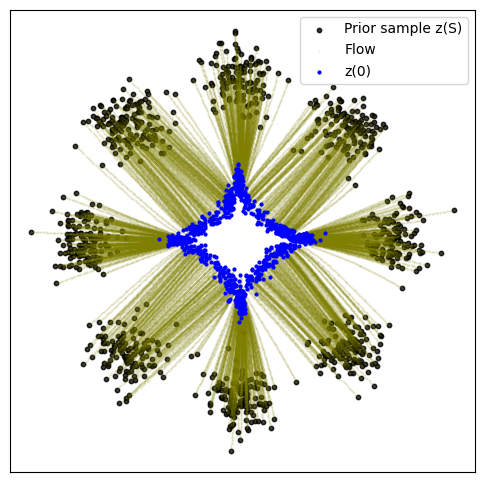

10000: loss 0.092 time 152.07


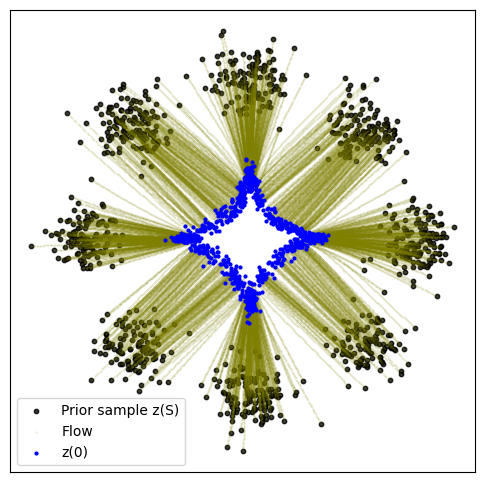

15000: loss 0.122 time 154.99


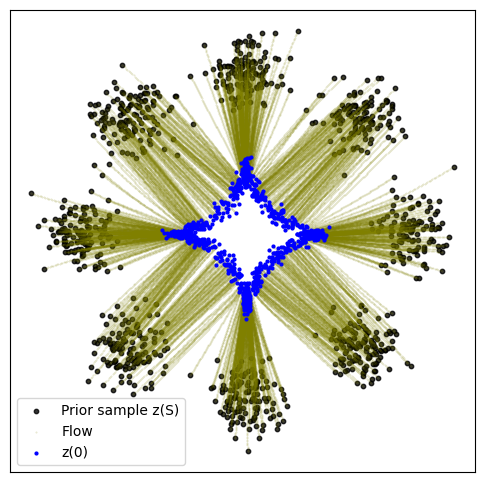

20000: loss 0.105 time 154.73


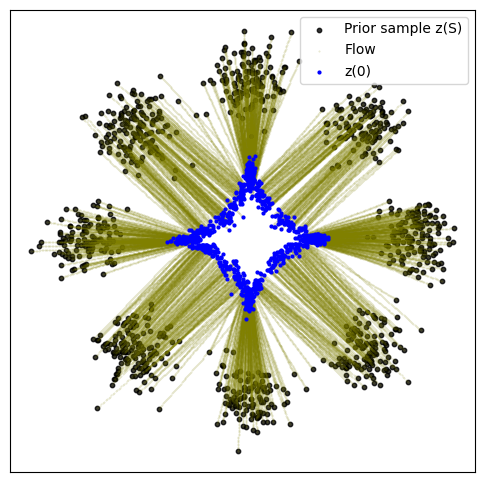

CPU times: total: 50min 29s
Wall time: 10min 14s


In [6]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1, _= generate_star(batch_size)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt -  ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())
torch.save(model, f"{savedir}/otcfm_v1.pt")

### Stochastic Interpolants (Albergo et al. 2023)

Next we try a variant suggested by Albergo et al. 2023, Stochastic Interpolants. This is an interesting interpolant because it has some variance preservation properties. Note that the authors consider $\sigma = 0$ (i.e. a Dirac around $\mu_t$) but we keep the general form for consistency. We also refer to this $t$ schedule as "Variance Preserving" and call this VP-CFM. The authors also consider optimizing over more general interpolants $I_t = \alpha(t) x_0 + \beta(t) x_1$ with minor constraints. In our notation, we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= q(x_0)q(x_1) \\
p_t(x | z) &= \mathcal{N}(x | \cos \left (\frac{\pi t}{2}  \right ) x_0 + \sin \left (\frac{\pi t}{2}  \right ) x_1, \sigma^2) \\
u_t(x | z) &= \frac{\pi}{2} \left (\cos (\frac{\pi t}{2}) x_1 - \sin(\frac{\pi t}{2}) x_0 \right )
\end{align}
$$

5000: loss 7.066 time 39.97


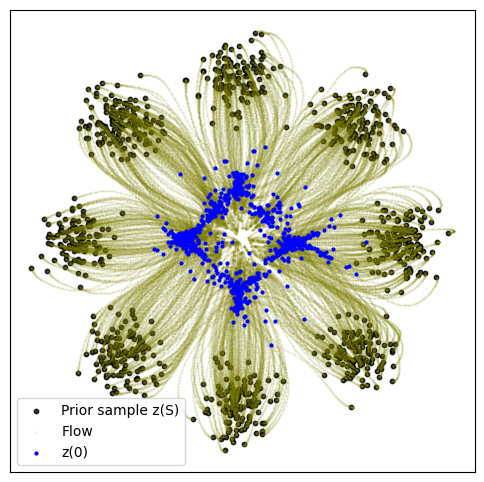

10000: loss 8.511 time 62.15


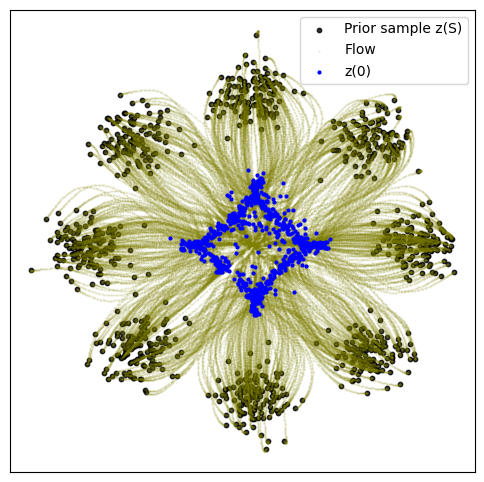

15000: loss 7.649 time 62.85


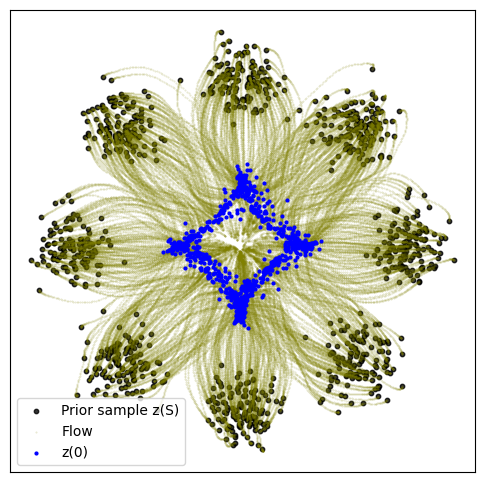

20000: loss 7.047 time 66.72


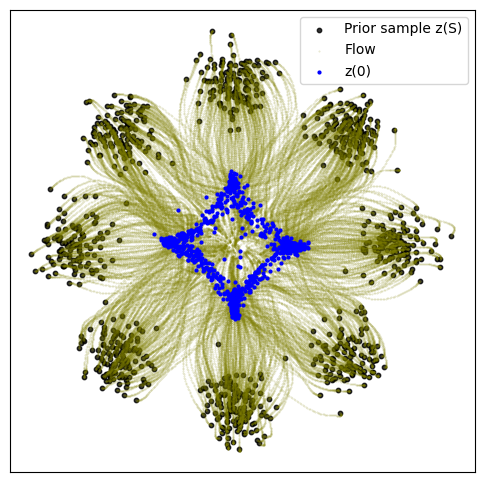

CPU times: total: 17min 30s
Wall time: 3min 54s
Parser   : 375 ms


In [7]:
%%time
sigma = 0.0
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
pi = math.pi

start = time.time()
for k in range(20000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    x0 = sample_8gaussians(batch_size)
    x1, _ = generate_star(batch_size)
    mu_t = torch.cos(pi / 2 * t) * x0 + torch.sin(pi / 2 * t) * x1
    sigma_t = sigma
    x = mu_t + sigma_t * torch.randn(batch_size, dim)
    ut = pi / 2 * (torch.cos(pi / 2 * t) * x1 - torch.sin(pi / 2 * t) * x0)
    vt = model(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())
torch.save(model, f"{savedir}/stochastic_interpolant_v1.pt")